# TP1 : Parcours des protons dans la mati` ere
### Physique Numérique (PHY-3500)
### Présenté à: Xavier Roy-Pomerleau
### Remis le: 21 février 2025

## Mise en contexte

Le traitement de tumeurs cancéreuses se fait souvent par radiothérapie. La radiothérapie utilise des particules accéléré à très grande énergie pour causer du dommage localisé dans la tumeur cancereuse. La particule la plus souvent utilisée pour cela est le proton, et il l'une des étapes initiales du traitement est de calculer l'énergie nécessaire de celui-ci afin de s'assurer de causer du dommage au bon endroit (la tumeur). 

Ce document résout le TP1 du cours de Physique Numérique (PHY-3500). 

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import timeit
from pathlib import Path
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

plt.rcParams["font.size"] = 12

## Numéro 1

The electronic density $n_e$ of a compound of $M$ elements is defined from its density $\rho$ and its composition of atoms of atomic numbers $N_i$ present with massic fractions of $f_i$ such that:
$$
    n_e = \rho\sum_{n=1}^MN_if_i
$$

In [53]:
def electronic_density(density, composition):
    """
    Calculate the electronic density of a compound.
    Params:
    density (float): The density of the compound in g/cm^3.
    composition (dict): A dictionary with the elements' atomic number as keys and a tuple 
        containing the massic fraction and the atomic mass in g/mol as values
    Returns:
    float: The electronic density of the compound in e-/cm^3.
    """
    avogadro = 6.022e23
    electronic_density = 0
    for z, (w, m) in composition.items():
        electronic_density += w * avogadro * z / m
    return electronic_density * density

In [54]:
# from NIST for liquid water (https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=276)
# the atomic masses are in u and come from: https://pubchem.ncbi.nlm.nih.gov/ptable/atomic-mass/
liquid_water_density = 1
liquid_water_composition = {1: (0.111894, 1.0080), 8: (0.888106, 15.999)} # {atomic number: (fraction, atomic mass)}
liquid_water_ne = electronic_density(liquid_water_density, liquid_water_composition)
print(f"The electronic density of liquid water is {liquid_water_ne:.2e} e-/cm^3.")

# from NIST for compact bone (https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=119)
compact_bone_density = 1.85
compact_bone_composition = {
    1: (0.063984, 1.0080), 6: (0.278000, 12.011), 7: (0.027000, 14.007), 
    8: (0.410016, 15.999), 12: (0.002000, 24.305), 15: (0.070000, 30.9738), 16: (0.002000, 32.08), 20: (0.147000, 40.08)
    }
compact_bone_ne = electronic_density(compact_bone_density, compact_bone_composition)
print(f"The electronic density of compact bone is {compact_bone_ne:.2e} e-/cm^3.")

The electronic density of liquid water is 3.34e+23 e-/cm^3.
The electronic density of compact bone is 5.91e+23 e-/cm^3.


## Numéro 2

The massic stopping power $S_{col, \rho}$ for a compound is defined like:
$$
\begin{aligned}
    S_{col, \rho} = \frac{S_{col}}{\rho} &= \frac{2\pi r_e^2m_ec^2n_e}{\rho\beta^2}\left[\ln\left(\frac{2m_ec^2(\gamma^2-1)T_e^{max}}{I^2}\right)-2\beta^2\right]\\
    &= \frac{U}{\rho}\left[\frac{\gamma^2}{\gamma^2-1}\ln\left(\frac{2m_ec^2(\gamma^2-1)T_e^{max}}{I^2}\right)-2\right]\\
\text{where } U=2\pi r_e^2m_ec^2n_e \text{ and } T_e^{max} \text{ is defined as:}\\
    T_e^{max} &= \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\left(\frac{m_e}{m_p}\right)+\left(\frac{m_e}{m_p}\right)^2}\\
\text{and } \gamma \text{ is defined as:}\\
    \gamma &= \frac{T}{m_pc^2}+1
\end{aligned}
$$

In [55]:
def massic_stopping_power(n_e, rho, T, I):
    """
    Calculate the massic stopping power of a material.
    Params: 
    n_e (float): The electronic density of the material in g/cm^3.
    rho (float): The density of the material in g/cm^3.
    T (float): The kinetic energy of the incident particle in MeV.
    I (float): The mean excitation energy of the material in MeV.
    Returns:
    float: The massic stopping power of the material in MeV cm^2/g.
    """
    c = 3e8 # speed of light in m/s 
    r_e = 2.8179e-13 # radius of the electron in cm
    m_e = 0.511/c**2 # mass of the electron in MeV/c^2
    m_p = 938.272/c**2 # mass of the proton in MeV/c^2

    gamma = T / (m_p * c**2) + 1
    T_e_max = (2 * m_e * c**2 * (gamma**2 - 1)) / (1 + 2 * gamma * (m_e / m_p) + (m_e / m_p)**2)
    U = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    S_col_rho = (U / rho) * ((gamma**2 / (gamma**2 - 1)) * np.log((2 * m_e * c**2 * (gamma**2 - 1) * T_e_max) / I**2) - 2)
    return S_col_rho

In [56]:
T = np.linspace(3, 250, 1000) # array of kinetic energies of the incident particle in MeV

liquid_water_I = 75e-6 # ionization energy of liquid water in MeV

massic_stopping_power_water = massic_stopping_power(liquid_water_ne, liquid_water_density, T, liquid_water_I)

compact_bone_I = 91.9e-6 # ionization energy of compact bone in MeV

massic_stopping_power_bone = massic_stopping_power(compact_bone_ne, compact_bone_density, T, compact_bone_I)

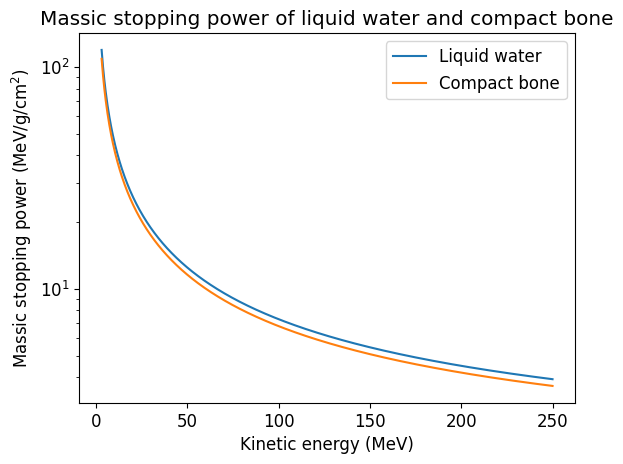

In [57]:
plt.plot(T, massic_stopping_power_water, label="Liquid water")  
plt.plot(T, massic_stopping_power_bone, label="Compact bone")
plt.yscale("log")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel(r"Massic stopping power (MeV/g/cm$^2$)")
plt.legend()
plt.title("Massic stopping power of liquid water and compact bone")
plt.show()

## Numéro 3

Lorsqu’un proton entre en collision avec la matière, deux principaux phénomènes entraînent sa décélération. Ces phénomènes sont les interactions nucléaires et les interactions radiatives.Les interactions nucléaires correspondent aux interactions entre les protons incidents et les noyaux présents dans la matière. Quant aux interactions radiatives, elles se produisent entre les protons incidents et les électrons du milieu.

Le NIST fournit une base de données identifiant l’ampleur de ces interactions individuelles. Voici ces interactions représentées dans un même graphique.

In [58]:
def read_pstar_data(filename):
    """
    Reads a text file and saves the data into a NumPy array.
    
    Parameters:
        filename (str): Path to the text file.
    
    Returns:
        np.ndarray: NumPy array containing the data.
    """
    try:
        path = os.getcwd() / Path("data") / Path(filename)
        data = np.loadtxt(path, delimiter=",", dtype=float, skiprows=8, usecols=(0, 1, 2, 3, 4, 5))
        return data
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
class Medium:
    """ A class to represent a medium with stopping power data. """
    def __init__(self, data):
        """ Initialize the Medium object with the stopping power data. """
        self.data = data
        self.nuclear_stoping_power = self.get_nuclear_stoping_power()
        self.electronic_stoping_power = self.get_electronic_stoping_power()
        self.total_stoping_power = self.get_total_stoping_power()

    def get_electronic_stoping_power(self):
        """ 
        Get the electronic stopping power data. 

        Returns:
            np.ndarray: NumPy array with the electronic stopping power data.
        """
        return np.column_stack((self.data[:, 0], self.data[:, 1]))
    
    def get_nuclear_stoping_power(self):
        """
        Get the nuclear stopping power data.

        Returns:
            np.ndarray: NumPy array with the nuclear stopping power data.
        """
        return np.column_stack((self.data[:, 0], self.data[:, 2]))
    
    def get_total_stoping_power(self):
        """
        Get the total stopping power data.

        Returns:
            np.ndarray: NumPy array with the total stopping power data.
        """
        return np.column_stack((self.data[:, 0], self.data[:, 3]))
    
    def graph_all_stoping_power(self, title="Stopping power"):
        """ Graph the electronic, nuclear, and total stopping power. """
        plt.plot(self.nuclear_stoping_power[:,0], self.nuclear_stoping_power[:,1], label="Nuclear stopping power")
        plt.plot(self.electronic_stoping_power[:,0], self.electronic_stoping_power[:,1], label="Electronic stopping power")
        plt.plot(self.total_stoping_power[:,0], self.total_stoping_power[:,1], label="Total stopping power", linestyle="--")
        plt.xlabel("Energy (MeV)")
        plt.ylabel("Stopping power (MeV cm^2/g)")
        plt.yscale("log")
        plt.title(title)
        plt.legend()
        plt.show()
        

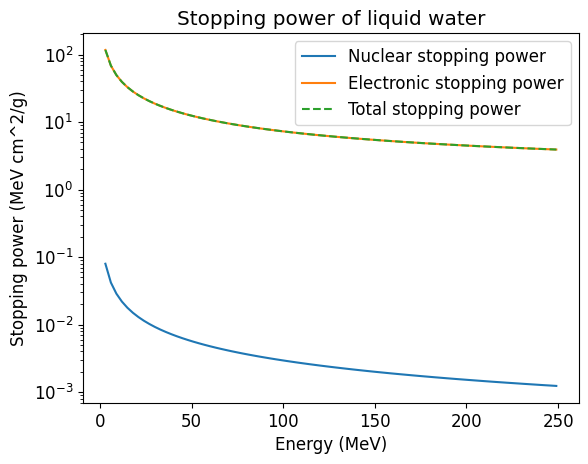

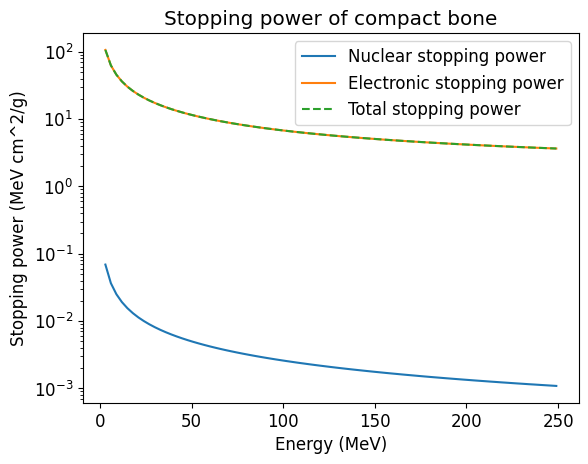

In [59]:
water = Medium(read_pstar_data("waterLiquidStoppingPower.txt"))
water.graph_all_stoping_power(title="Stopping power of liquid water")

bone = Medium(read_pstar_data("boneLiquidStoppingPower.txt"))
bone.graph_all_stoping_power(title="Stopping power of compact bone")


## Numéro 4

Plus le pouvoir d'arrêt d'un matériel est grand, plus la portée de la particule sera faible dans le matériel. Il est donc logique et intuitif de dire que la portée suit une tendance inverse au pouvoir d'arrêt. 

Il est également possible de démontrer cela en utilisant les unités. Nous cherchons une portée (unités: cm, dimension: $L$) à partir du pouvoir d'arrêt (unités: MeV/cm, dimensions: $ML/T^2$) et de l'énergie (unités: MeV, dimensions: $ML^2/T^2$). Notre seul moyen d'obtenir la dimension adéquate pour la portée est de multiplier les dimensions de l'énergie par les dimensions de l'inverse du pouvoir d'arrêt : $ML^2/T^2 \cdot (ML/T^2)^{-1} = L$.

C'est exactement ce que nous retrouvons pour la formule de la portée CSDA: $R_{CSDA} = \int_0^{T_i} \frac{1}{S} dT$

## Numéro 5

La formule pour le pouvoir d'arrêt est relativement complexe, et nous nous retrouvons avec une intégrale de forme $\int \frac{1}{ln(T)+B} dT$, où B est une constante. Cette intégrale ne produit pas de solution analytique, et donc l'utilisation d'une méthode numérique est nécessaire.  

## Numéro 6

In [60]:
def total_stopping_power(n_e, T, I):
    """
    Calculate the massic stopping power of a material.
    Params: 
    n_e (float): The electronic density of the material in g/cm^3.
    rho (float): The density of the material in g/cm^3.
    T (float): The kinetic energy of the incident particle in MeV.
    I (float): The mean excitation energy of the material in MeV.
    Returns:
    float: The massic stopping power of the material in MeV cm^2/g.
    """
    c = 3e8 # speed of light in m/s 
    r_e = 2.8179e-13 # radius of the electron in cm
    m_e = 0.511/c**2 # mass of the electron in MeV/c^2
    m_p = 938.272/c**2 # mass of the proton in MeV/c^2

    gamma = T / (m_p * c**2) + 1
    T_e_max = (2 * m_e * c**2 * (gamma**2 - 1)) / (1 + 2 * gamma * (m_e / m_p) + (m_e / m_p)**2)
    U = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    S_col = (U ) * ((gamma**2 / (gamma**2 - 1)) * np.log((2 * m_e * c**2 * (gamma**2 - 1) * T_e_max) / I**2) - 2)
    return S_col

def stopping_power_array(a, b, n_slice, n_e, I):
    X = np.linspace(a, b, n_slice+1)
    Y = total_stopping_power(n_e, X, I)
    return X,Y

In [61]:
def trapezoidal_integration(x, y):
    """ 
    Perform trapezoidal integration on the data.

    Parameters:
        x (np.ndarray): NumPy array with the x values.
        y (np.ndarray): NumPy array with the y values.

    Returns:
        float: The integral of the data.
    """
        
    # We set gobal variable for result
    integral = 0

    for i in range(len(x) - 1):
        # Calculate high of the trapezoid
        h = x[i+1] - x[i]
        # Calculate area of the trapezoid
        integral += (y[i] + y[i+1]) * h / 2
        
    return integral

In [62]:
electron_energy = 150

water_x_total_stopping_power, water_y_total_stopping_power = stopping_power_array(3, electron_energy, 1000, liquid_water_ne, liquid_water_I)
bone_x_total_stopping_power, bone_y_total_stopping_power = stopping_power_array(3, electron_energy, 1000, compact_bone_ne, compact_bone_I)

# calculate the range of the proton in water and bone
proton_range_water = trapezoidal_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1)
proton_range_bone = trapezoidal_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1)

# We print the results
print("Valeur calculée de la portée du proton ayant une énergie de {:.6f} MeV dans l'eau liquide: {:.6f} cm".format(electron_energy, proton_range_water))
print("Valeur calculée de la portée du proton ayant une énergie de {:.6f} MeV dans l'os compact: {:.6f} cm".format(electron_energy, proton_range_bone))

Valeur calculée de la portée du proton ayant une énergie de 150.000000 MeV dans l'eau liquide: 15.753600 cm
Valeur calculée de la portée du proton ayant une énergie de 150.000000 MeV dans l'os compact: 9.159945 cm


In [63]:
def romberg_integration(x, y, min_err = 0):
    """
    Perform Romberg integration on the data.
    x : x values (np.array of size (n,))
    y : y values (np.array of size (n,))
    min_err : minimum error for the Romberg method (float)
    n_slice : number of slices for the trapezoidal integration (int)

    Returns:
    float: The integral of the data.
    """
    # We find the number of points
    m = len(x)
    # 2**max_step == m
    max_step = int(np.log(m) / np.log(2))

    # We initialize an array in which we will store the results of the extrapolation
    romberg_array = np.zeros((max_step, max_step))
    
    # We fill the first column with trapezoidal integration results
    for i in range(max_step, 0, -1):
        # Number of points used
        step = 2**i
        # Indices of the points used
        indices = np.arange(0, m + 1, step)
        # We calculate the trapezoidal integration
        romberg_array[max_step - i, 0] = trapezoidal_integration(x[indices], y[indices])

    # We apply the Romberg method to extrapolate the results
    for j in range(1, max_step):
        for i in range(1, max_step):
            if (i >= j):
                # We apply the Romberg method
                romberg_array[i, j] = (4**j * romberg_array[i, j-1] - romberg_array[i-1, j-1]) / (4**j - 1)
            if (i == j) and (i > 0):
                # We check if the error is smaller than the minimum error
                if (abs(romberg_array[i, j] - romberg_array[i-1, j-1]) < min_err):
                    return romberg_array[i, j]

    # We return the result of the last extrapolation
    return romberg_array[max_step-1, max_step-1]

In [64]:
# We set minimal error tolerance
minimal_error = 1e-6

# We calculate the proton range in water and bone
proton_range_water = romberg_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1, minimal_error)

# We print the results
print("Valeur calculée de la portée du proton ayant une énergie de {:.6f} MeV dans l'eau liquide: {:.6f} cm".format(electron_energy, proton_range_water))

# We calculate the proton range in bone
proton_range_bone = romberg_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1, minimal_error)

# We print the results
print("Valeur calculée de la portée du proton ayant une énergie de {:.6f} MeV dans l'os compact: {:.6f} cm".format(electron_energy, proton_range_bone))

Valeur calculée de la portée du proton ayant une énergie de 150.000000 MeV dans l'eau liquide: 15.753712 cm
Valeur calculée de la portée du proton ayant une énergie de 150.000000 MeV dans l'os compact: 9.160010 cm


## Numéro 7

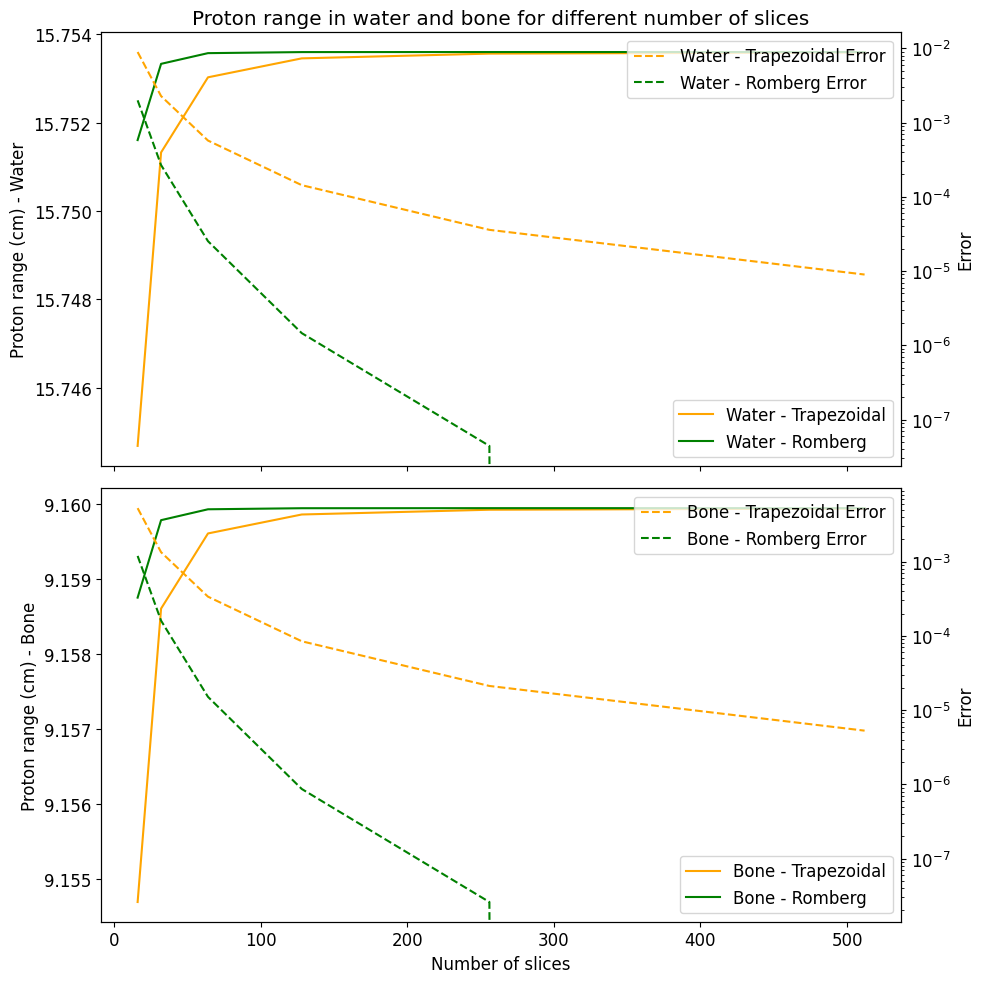

In [79]:
# Due to our sample rate we are stuck with those slices number
n_slice_selection = [16, 32, 64 ,128, 256, 512]

# We initialize the results
water_integration_results_trapezoidal = []
water_integration_results_romberg = []
bone_integration_results_trapezoidal = []
bone_integration_results_romberg = []

# We calculate the proton range in water and bone for different number of slices and add the results to the lists
for n_slice in n_slice_selection:
    
    water_x_total_stopping_power, water_y_total_stopping_power = stopping_power_array(3, electron_energy, n_slice, liquid_water_ne, liquid_water_I)
    bone_x_total_stopping_power, bone_y_total_stopping_power = stopping_power_array(3, electron_energy, n_slice, compact_bone_ne, compact_bone_I)

    # Trapezoidal integration for water
    water_integration_results_trapezoidal.append(trapezoidal_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1))
    # Romberg integration for water
    water_integration_results_romberg.append(romberg_integration(water_x_total_stopping_power, water_y_total_stopping_power**-1))
    # Trapezoidal integration for bone
    bone_integration_results_trapezoidal.append(trapezoidal_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1))
    # Romberg integration for bone
    bone_integration_results_romberg.append(romberg_integration(bone_x_total_stopping_power, bone_y_total_stopping_power**-1))

# We initialize the results
error_water_integration_results_trapezoidal = []
error_water_integration_results_romberg = []
error_bone_integration_results_trapezoidal = []
error_bone_integration_results_romberg = []

supposed_exact_value_water = water_integration_results_romberg[-1]
supposed_exact_value_bone = bone_integration_results_romberg[-1]

for i in range(len(n_slice_selection)):
    error_water_integration_results_trapezoidal.append(np.abs(water_integration_results_trapezoidal[i] - supposed_exact_value_water))
    error_water_integration_results_romberg.append(np.abs(water_integration_results_romberg[i] - supposed_exact_value_water))
    error_bone_integration_results_trapezoidal.append(np.abs(bone_integration_results_trapezoidal[i] - supposed_exact_value_bone))
    error_bone_integration_results_romberg.append(np.abs(bone_integration_results_romberg[i] - supposed_exact_value_bone))

# Create the figure and primary axis
fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True)
# Plot the first line (Left Y-axis)
ax[0].plot(n_slice_selection, water_integration_results_trapezoidal, label="Water - Trapezoidal", color="orange", linestyle="-")
ax[0].plot(n_slice_selection, water_integration_results_romberg, label="Water - Romberg", color="green", linestyle="-")
ax[0].set_ylabel("Proton range (cm) - Water")
ax[0].legend()
ax[0].title.set_text("Proton range in water and bone for different number of slices")

ax_error_water = ax[0].twinx()
ax_error_water.plot(n_slice_selection, error_water_integration_results_trapezoidal, label="Water - Trapezoidal Error", color="orange", linestyle="--")
ax_error_water.plot(n_slice_selection, error_water_integration_results_romberg, label="Water - Romberg Error", color="green", linestyle="--")
ax_error_water.set_ylabel("Error")
ax_error_water.legend()
ax_error_water.set_yscale("log")


# Create secondary axis (Right Y-axis)
ax[1].plot(n_slice_selection, bone_integration_results_trapezoidal, label="Bone - Trapezoidal", color="orange", linestyle="-")
ax[1].plot(n_slice_selection, bone_integration_results_romberg, label="Bone - Romberg", color="green", linestyle="-")
ax[1].set_ylabel("Proton range (cm) - Bone")
ax[1].set_xlabel("Number of slices")
ax[1].legend()

ax_error_bone = ax[1].twinx()
ax_error_bone.plot(n_slice_selection, error_bone_integration_results_trapezoidal, label="Bone - Trapezoidal Error", color="orange", linestyle="--")
ax_error_bone.plot(n_slice_selection, error_bone_integration_results_romberg, label="Bone - Romberg Error", color="green", linestyle="--")
ax_error_bone.set_ylabel("Error")
ax_error_bone.legend()
ax_error_bone.set_yscale("log")


plt.tight_layout()
plt.show()

## Numéro 8

Nous allons dériver à la main l'expression. Nous cherchons donc la solution de l'expression suivante:
$$\begin{align}
\frac{d}{dT}S_{col} = \frac{d}{dT}\left(2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2}[\ln(\frac{2m_ec^2\beta^2\gamma^2T_e^{max}}{I^2}-2\beta^2)]\right)
\end{align}$$
En utilisant $U=2\pi r_e^2 m_e c^2 n_e$ et $a=2m_ec^2$, nous simplifions en combinant des paramètres qui ne dépendent pas de T:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d}{dT}\left( \frac{1}{\beta^2}[\ln(\frac{a\beta^2\gamma^2T_e^{max}}{I^2}-2\beta^2)]\right)
\end{align}$$
En remplaçant $T_e^{max} = \frac{a(\gamma^2-1)}{b+\delta\gamma}$, et subséquemment en utilisant $k=\frac{a^2}{I^2}$, nous avons:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d}{dT}\left( \frac{1}{\beta^2}\left[\ln\left(\frac{k\beta^2\gamma^2(\gamma^2-1)}{(b+\delta\gamma)}-2\beta^2\right)\right]\right)
\end{align}$$
On exprime ensuite tout en fonction de $\gamma$:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d}{dT}\left( \frac{\gamma^2}{\gamma^2 - 1}\left[\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)\right]\right)
\end{align}$$
Puisque $\gamma$ est une fonction de $T$, on peut dériver l'expression ci-haut par rapport à $\gamma$ et multiplier par la dérivée de $\gamma$ par rapport à $T$ (dérivée en chaine):
$$\begin{align}
\frac{d}{dT}S_{col} = U\left[\frac{d}{d\gamma}\left( \frac{\gamma^2}{\gamma^2 - 1}\left[\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)\right]\right) \cdot \frac{d\gamma}{dT}\right]
\end{align}$$
On évalue donc la dérivée:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d\gamma}{dT}\cdot\left(-\frac{2\gamma}{(\gamma^2-1)^2}\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)+\frac{3\delta\gamma^7+4b\gamma^6-6\delta\gamma^5-8b\gamma^4+7\delta\gamma^3+8b\gamma^2+4\delta\gamma-4b}{\gamma^3(\gamma+1)^2(\gamma-1)^2(b+\delta\gamma)}\cdot\frac{\gamma^2}{\gamma^2-1}\right)
\end{align}$$
On dérive finalement $\gamma$ selon $T$ et on obtient l'expression finale:
$$\begin{align}
\frac{d}{dT}S_{col} = \frac{U}{m_pc^2}\cdot\left(-\frac{2\gamma}{(\gamma^2-1)^2}\ln\left(\frac{k(\gamma^2-1)^2}{(b+\delta\gamma)}-2\frac{\gamma^2 - 1}{\gamma^2}\right)+\frac{3\delta\gamma^7+4b\gamma^6-6\delta\gamma^5-8b\gamma^4+7\delta\gamma^3+8b\gamma^2+4\delta\gamma-4b}{\gamma^3(\gamma+1)^2(\gamma-1)^2(b+\delta\gamma)}\cdot\frac{\gamma^2}{\gamma^2-1}\right)
\end{align}$$
où $\gamma=\frac{T}{m_pc^2}+1$, $U=2\pi r_e^2 m_e c^2 n_e$, $k=\frac{(2m_ec^2)^2}{I^2}$, $b=1+\left(\frac{m_e}{m_p}\right)^2$ et $\delta=\frac{2m_e}{m_p}$.


<!-- 
On exprime toute les dépendances de T en utilisant $\beta^2\gamma^2 = (\gamma^2-1)$, $\beta = \frac{2T}{m_p}$ et $\gamma = \frac{T}{m_pc^2} + 1$:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d}{dT}\left( \frac{1}{(\frac{2T}{m_p})^2}\left[ln\left(\frac{k((\frac{T}{m_pc^2} + 1)^2-1)^2}{b+\delta(\frac{T}{m_pc^2} + 1)}-2(\frac{2T}{m_p})^2\right)\right]\right)
\end{align}$$
En développant les termes avec T, on retrouve une équation qui nous permettra de commencer notre dérivation:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d}{dT}\left( \frac{m_p^2}{4T^2} \left[ln\left(\frac{k(\frac{T^2}{m_p^2c^4} + \frac{2T}{m_pc^2})^2}{b+\delta(\frac{T}{m_pc^2}+1)} - \frac{8T^2}{m_p^2}\right)\right] \right)
\end{align}$$
En posant $A = \frac{m_p^2}{4T^2}$ et $B = ln\left(\frac{k(\frac{T^2}{m_p^2c^4} + \frac{2T}{m_pc^2})^2}{b+\delta(\frac{T}{m_pc^2}+1)} - \frac{8T^2}{m_p^2}\right)$, et en utilisant la dérivée de fonction composée, on se retrouve avec la formule suivante:
$$\begin{align}
\frac{d}{dT}S_{col} = U\frac{d}{dT}\left( A \cdot B \right) = U \left[\left(\frac{d}{dT}A\right) \cdot B + \left(\frac{d}{dT}B\right) \cdot A\right]
\end{align}$$ -->

## Numéro 9

## Numéro 10

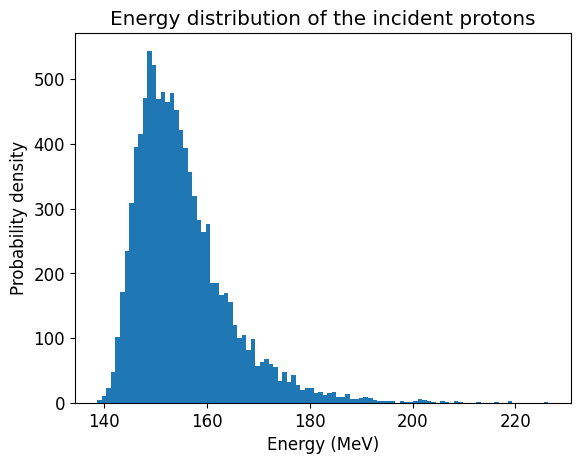

In [66]:
energy_dist = stats.moyal(loc=150, scale=4) # energy distribution

n = 10000 # number of particles

energies = energy_dist.rvs(n) # array of energies

plt.hist(energies, bins=100)
plt.xlabel("Energy (MeV)")
plt.ylabel("Probability density")
plt.title("Energy distribution of the incident protons")
plt.show()

## Numéro 11

## Numéro 12

## Numéro 13

## Numéro 14

## Numéro 15

## Numéro 16

## Numéro 17